<a href="https://colab.research.google.com/github/MaureenOShea/WiDS25_data-sleuthing/blob/main/wids_usaid_africa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Sleuthing the Headlines**
## Investigating the Economic Relationship Between USAID Funding and Africa

In this notebook, we take on the role of a data **detective** to explore how **U.S. foreign aid (USAID)** relates to **GDP in Africa**. Using Python in a Google Colab environment, we'll clean and analyze real-world data to uncover patterns in aid distribution and economic development.

We’ll investigate:

* Trends in USAID funding over time

* Which countries receive the most aid and least aid

* USAID funding by Aid Category

* The relationship between aid and GDP

Let’s dig in and uncover the story the data tells about aid and growth in Africa.            

---

####Data Reference:

**World Bank** (Accessed March 2025)
World Development Indicators

* GDP (current US$) - [NY.GDP.MKTP.CD](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD)
* Population, total - [SP.POP.TOTL](https://data.worldbank.org/indicator/SP.POP.TOTL)

**ForeignAssistance.gov** (Accessed March 2025)  
https://foreignassistance.gov/data

*Stewards: U.S. Agency for International Development (USAID) and U.S. Department
of State on behalf of United States Government agencies reporting foreign assistance.*

# Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Display tables
from IPython.display import display

# Display plots inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Read Data

In [2]:
path = "https://raw.githubusercontent.com/MaureenOShea/WiDS25_data-sleuthing/refs/heads/main/"

filename = "usaid_africa_foreignassistance_data.csv"
usaid = pd.read_csv(path + filename)

filename = 'gdp_africa_worldbank_data.csv'
wb = pd.read_csv(path + filename)

In [3]:
# Display basic info
display(usaid.info())
display(usaid.head())
display(wb.info())
display(wb.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422305 entries, 0 to 422304
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Country Code          422305 non-null  object
 1   Country Name          422305 non-null  object
 2   Income Group Acronym  422305 non-null  object
 3   US Category Name      422305 non-null  object
 4   Year                  422305 non-null  int64 
 5   Amount USD            422305 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 19.3+ MB


None

,Country Code,Country Name,Income Group Acronym,US Category Name,Year,Amount USD
0,DZA,Algeria,UMIC,Humanitarian Assistance,2015,137383
1,DZA,Algeria,UMIC,Humanitarian Assistance,2015,118499
2,DZA,Algeria,UMIC,Humanitarian Assistance,2016,361967
3,DZA,Algeria,UMIC,Humanitarian Assistance,2016,703308
4,DZA,Algeria,UMIC,Humanitarian Assistance,2016,568517


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  530 non-null    object 
 1   Year          530 non-null    int64  
 2   GDP USD       530 non-null    float64
 3   Population    530 non-null    int64  
 4   Country Code  530 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 20.8+ KB


None

,Country Name,Year,GDP USD,Population,Country Code
0,Algeria,2014,2.389427e+11,39205031,DZA
1,Algeria,2015,1.874939e+11,40019529,DZA
2,Algeria,2016,1.807638e+11,40850721,DZA
3,Algeria,2017,1.898809e+11,41689299,DZA
4,Algeria,2018,1.945545e+11,42505035,DZA


## Preprocessing

## Merge USAID and World Bank data: merged_df

In [4]:
# Merge USAID data with World Bank population data
merged_df = pd.merge(usaid,wb[["Country Code", "Year", "Population", "GDP USD"]],on=["Country Code", "Year"],how="left")

# Drop records with missing population
merged_df = merged_df.dropna(subset=["Population","GDP USD"])

# Combine specified US Category Name categories
combined_categories = ['Democracy, Human Rights, and Governance', 'Education and Social Services', 'Peace and Security', 'Environment']
merged_df['US Category Name'] = merged_df['US Category Name'].apply(lambda x: 'Combined Categories' if x in combined_categories else x)

#
merged_df = merged_df.groupby(["Year","Country Code","Income Group Acronym", "US Category Name","Country Name",]).agg({
    "Amount USD": "sum", "Population": "mean", "GDP USD":"mean"}).reset_index()

display(merged_df)


,Year,Country Code,Income Group Acronym,US Category Name,Country Name,Amount USD,Population,GDP USD
0,2014,AGO,LMIC,Combined Categories,Angola,1848569,27160769.0,1.359668e+11
1,2014,AGO,LMIC,Economic Development,Angola,40173,27160769.0,1.359668e+11
2,2014,AGO,LMIC,Health,Angola,42405273,27160769.0,1.359668e+11
3,2014,AGO,LMIC,Humanitarian Assistance,Angola,4219014,27160769.0,1.359668e+11
4,2014,AGO,LMIC,Program Support,Angola,7076091,27160769.0,1.359668e+11
...,...,...,...,...,...,...,...,...
1952,2023,ZWE,LMIC,Combined Categories,Zimbabwe,22916610,16340822.0,3.523137e+10
1953,2023,ZWE,LMIC,Economic Development,Zimbabwe,11098738,16340822.0,3.523137e+10
1954,2023,ZWE,LMIC,Health,Zimbabwe,118548383,16340822.0,3.523137e+10
1955,2023,ZWE,LMIC,Humanitarian Assistance,Zimbabwe,93973312,16340822.0,3.523137e+10


In [18]:
display(merged_df.info())

# # get unique values for categorical columns

# for column in merged_df.columns:
#   if merged_df[column].dtype == 'object':
#     display(f"Unique values for {column}: {merged_df[column].unique()}")
#     display(f"Unique value count for {column} : {merged_df[column].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  1957 non-null   int64  
 1   Country Code          1957 non-null   object 
 2   Income Group Acronym  1957 non-null   object 
 3   US Category Name      1957 non-null   object 
 4   Country Name          1957 non-null   object 
 5   Amount USD            1957 non-null   int64  
 6   Population            1957 non-null   float64
 7   GDP USD               1957 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 122.4+ KB


None

In [6]:
display(merged_df.describe())

,Year,Amount USD,Population,GDP USD
count,1957.000000,1.957000e+03,1.957000e+03,1.957000e+03
mean,2018.487481,4.228973e+07,3.122346e+07,5.768029e+10
std,2.906250,9.253959e+07,3.929850e+07,1.024584e+11
min,2014.000000,-7.590400e+05,9.135900e+04,2.599996e+08
25%,2016.000000,2.432308e+06,9.304337e+06,9.879232e+09
50%,2018.000000,1.570445e+07,1.807757e+07,1.740175e+10
75%,2021.000000,3.842673e+07,3.502346e+07,5.172676e+10
max,2023.000000,1.326250e+09,2.278829e+08,5.741838e+11


# EDA



## Trends over Time
1. Aggregate overall USAID funding and USAID funding by category and income group.

2. Visualize trends over time and ask the following questions:


*   Are USAID funding levels rising or falling over time across Africa?
*   Do funding spikes align with GDP downturns (e.g., during crises)?

### Total USAID to AFRICA over Time

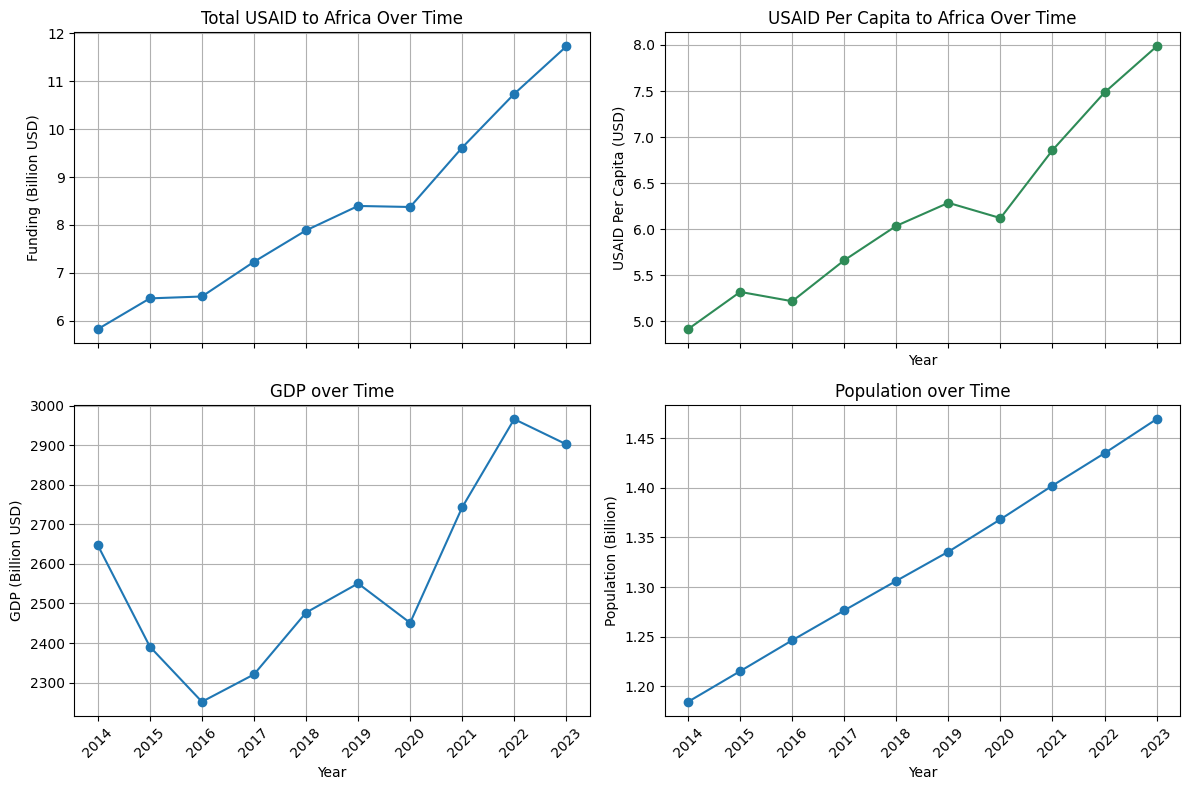

In [7]:
# --- Total USAID and Per Capita USAID Funding by Year ---

# Step 1: Aggregate funding at the country-year level
country_year_df = merged_df.groupby(["Year","Country Name",
                                     "Income Group Acronym"]).agg({"Amount USD": "sum",
                                                                   "Population": "mean",
                                                                   "GDP USD":"mean"}).reset_index()

# Step 2: Aggregate to year level for total funding and population
year_df = country_year_df.groupby(["Year"]).agg({"Amount USD": "sum",
                                                 "Population": "sum",
                                                 "GDP USD":"sum"}).reset_index()

# Total USAID Funding (in billions)
year_df["Amount (Billion USD)"] = year_df["Amount USD"] / 1e9

# Step 3: Compute per capita funding
year_df["Amount Per Capita USD"] = (year_df["Amount USD"] / year_df["Population"])

# --- Total GDP for each year in Billions ---
year_df["GDP (Billion USD)"] = year_df["GDP USD"] / 1e9

# --- Total Population for each year in Billions  ---
year_df["Population (Billion)"] = year_df["Population"] / 1e9

# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot 1: Total USAID Funding (in billions)
axes[0, 0].plot(year_df["Year"], year_df["Amount (Billion USD)"], marker='o',)
axes[0, 0].set_title("Total USAID to Africa Over Time")
axes[0, 0].set_ylabel("Funding (Billion USD)")
axes[0, 0].grid(True)

# Plot 2: USAID Per Capita Funding
axes[0, 1].plot(year_df["Year"], year_df["Amount Per Capita USD"], marker='o', color='seagreen')
axes[0, 1].set_title("USAID Per Capita to Africa Over Time")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("USAID Per Capita (USD)")
axes[0, 1].grid(True)

# Plot 3: GDP
axes[1, 0].plot(year_df["Year"], year_df["GDP (Billion USD)"], marker='o',)
axes[1, 0].set_title('GDP over Time')
axes[1, 0].set_ylabel('GDP (Billion USD)')
axes[1, 0].set_xlabel("Year")
axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xticks(year_df["Year"]) # Set xticks to all years

# Plot 4: Population
axes[1, 1].plot(year_df["Year"], year_df["Population (Billion)"] , marker='o')
axes[1, 1].set_title('Population over Time')
axes[1, 1].set_ylabel('Population (Billion)')
axes[1, 1].set_xlabel("Year")
axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_xticks(year_df["Year"]) # Set xticks to all years

# Final layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### USAID to AFRICA by Category and Income Group over Time

### US Categories
1. Humanitarian Assistance
2. Health
3. Program Support
4. Economic Development
5. Combined Categories:
> Democracy, Human Rights, and Governance  
> Education and Social Services  
> Peace and Security  
> Environment  

### Income Groups

The World Bank classifies countries into four income groups based on Gross National Income (GNI) per capita

Income Group Acronyms:
* **LIC (Low income economies)**: GNI per capita of \$1,145 or less in 2023.
* **LMIC (Lower-middle-income economies)**: GNI per capita between \$1,146 and \$4,515 in 2023.
* **UMIC (Upper-middle-income economies)**: GNI per capita between \$4,516 and \$14,005 in 2023.
* **HIC (High-income economies)**: GNI per capita of more than \$14,005 in 2023.

In [8]:
# Countries belonging to each Income Group

# Group by 'Income Group Acronym' and get unique countries within each group
income_group_countries = merged_df.groupby('Income Group Acronym')['Country Name'].unique()

# Print the results
for income_group, countries in income_group_countries.items():
  print(f"{income_group}: {countries}")
  print("`\n")

HIC: ['Seychelles']
`

LIC: ['Burundi' 'Benin' 'Burkina Faso' 'Central African Republic'
 'Congo (Kinshasa)' 'Ethiopia' 'Guinea' 'Gambia' 'Guinea-Bissau' 'Liberia'
 'Madagascar' 'Mali' 'Mozambique' 'Malawi' 'Niger' 'Rwanda' 'Sierra Leone'
 'Somalia' 'South Sudan' 'Chad' 'Togo' 'Tanzania' 'Uganda']
`

LMIC: ['Angola' "Cote d'Ivoire" 'Cameroon' 'Congo (Brazzaville)' 'Comoros'
 'Cabo Verde' 'Djibouti' 'Egypt' 'Ghana' 'Kenya' 'Lesotho' 'Morocco'
 'Mauritania' 'Nigeria' 'Sudan' 'Senegal' 'Sao Tome and Principe'
 'Eswatini' 'Tunisia' 'Zambia' 'Zimbabwe']
`

UMIC: ['Botswana' 'Algeria' 'Gabon' 'Equatorial Guinea' 'Libya' 'Mauritius'
 'Namibia' 'South Africa']
`



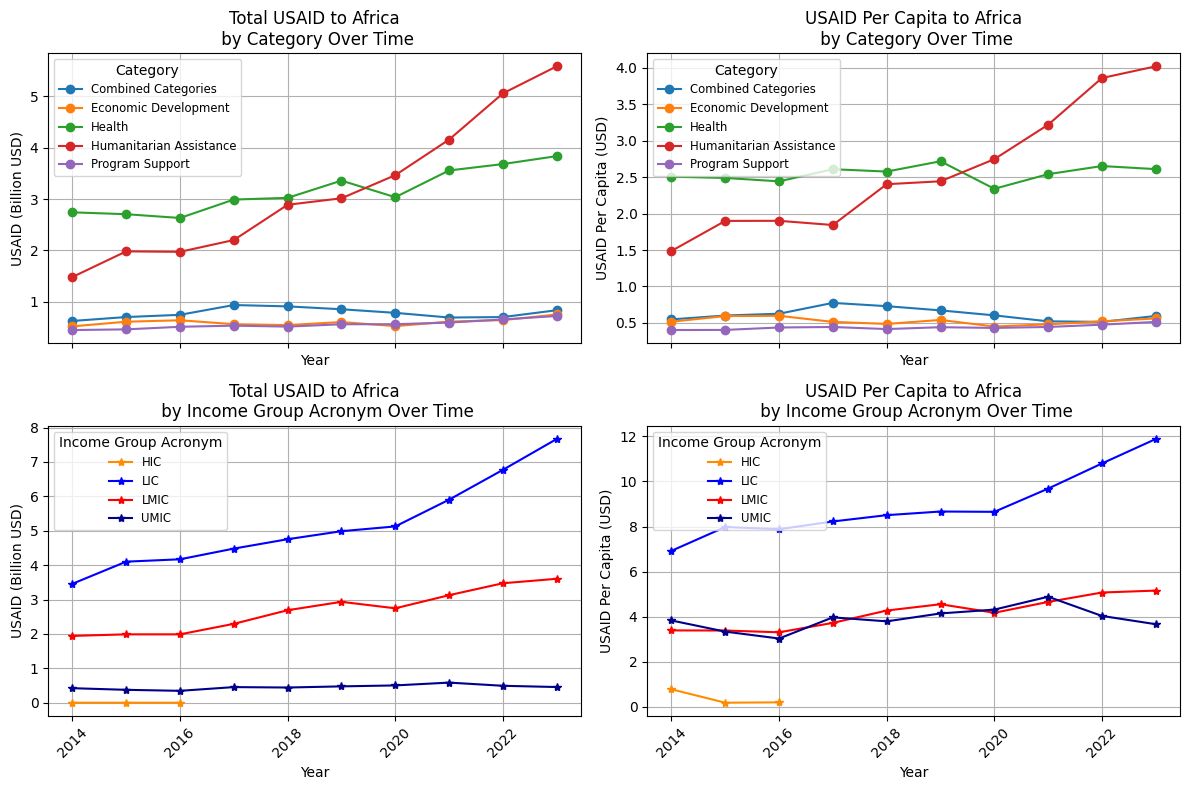

In [9]:
# --- USAID by Category by Year ---
funding_by_category_year_df = (merged_df.groupby(["Year", "US Category Name"])["Amount USD"].sum().reset_index())

funding_by_category_year_df["Amount (Billion USD)"] = funding_by_category_year_df["Amount USD"] / 1e9

pivot_total = funding_by_category_year_df.pivot(index="Year", columns="US Category Name", values="Amount (Billion USD)")

# --- Per Capita USAID by Category by Year ---

# Step 1: Aggregate funding at the country-year level
category_country_year_df = merged_df.groupby(["Year", "US Category Name", "Country Code", "Population"])["Amount USD"].sum().reset_index()

# Step 2: Calculate US category level
category_year_df = category_country_year_df.groupby(["Year", "US Category Name"])[["Amount USD", "Population"]].sum().reset_index()

# Step 3: Amount Per Capita (USD) by year
category_year_df["Amount Per Capita (USD)"] = category_year_df["Amount USD"] / category_year_df["Population"]

pivot_per_capita = category_year_df.pivot(index="Year", columns="US Category Name", values="Amount Per Capita (USD)")

# --- USAID by Income Group Acronym by Year ---
funding_by_ig = (merged_df.groupby(["Year", "Income Group Acronym"])["Amount USD"].sum().reset_index())

funding_by_ig["Amount (Billion USD)"] = funding_by_ig["Amount USD"] / 1e9

pivot_total_ig = funding_by_ig.pivot(index="Year", columns="Income Group Acronym", values="Amount (Billion USD)")

# --- Per Capita USAID Income Group Acronym by Year ---

# Step 1: Aggregate funding at the country-year level
ig_country_year_df = merged_df.groupby(["Year", "Income Group Acronym", "Country Code", "Population"])["Amount USD"].sum().reset_index()

# Step 2: Calculate US category level
per_capita_funding_by_ig_year = ig_country_year_df.groupby(["Year", "Income Group Acronym"])[["Amount USD", "Population"]].sum().reset_index()

# Step 3: Amount Per Capita (USD) by year
per_capita_funding_by_ig_year["Amount Per Capita (USD)"] = per_capita_funding_by_ig_year["Amount USD"] / per_capita_funding_by_ig_year["Population"]
per_capita_funding_by_ig_year

pivot_per_capita_ig = per_capita_funding_by_ig_year.pivot(index="Year", columns="Income Group Acronym", values="Amount Per Capita (USD)")
# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot 1
for column in pivot_total.columns:
    axes[0, 0].plot(pivot_total.index, pivot_total[column], marker='o', label=column)
    axes[0, 0].set_title("Total USAID to Africa\n by Category Over Time")
    axes[0, 0].set_ylabel("USAID (Billion USD)")
    axes[0, 0].set_xlabel("Year")
    axes[0, 0].grid(True)
    axes[0, 0].legend(title="Category", loc="upper left", fontsize='small')
    axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2
for column in pivot_per_capita.columns:
    axes[0, 1].plot(pivot_per_capita.index, pivot_per_capita[column], marker='o', label=column)
    axes[0, 1].set_title("USAID Per Capita to Africa\n by Category Over Time")
    axes[0, 1].set_ylabel("USAID Per Capita (USD)")
    axes[0, 1].set_xlabel("Year")
    axes[0, 1].grid(True)
    axes[0, 1].legend(title="Category",loc="upper left", fontsize='small')
    axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3
colors = ['darkorange', 'blue','red', 'darkblue'] # Define a list of colors
for i, column in enumerate(pivot_total_ig.columns):
    axes[1, 0].plot(pivot_total_ig.index, pivot_total_ig[column], marker='*', label=column, color=colors[i % len(colors)])
    axes[1, 0].set_title("Total USAID to Africa\n by Income Group Acronym Over Time")
    axes[1, 0].set_ylabel("USAID (Billion USD)")
    axes[1, 0].set_xlabel("Year")
    axes[1, 0].grid(True)
    axes[1, 0].legend(title="Income Group Acronym", loc="upper left", fontsize='small')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4
for i, column in enumerate(pivot_per_capita_ig.columns):
    axes[1, 1].plot(pivot_per_capita_ig.index, pivot_per_capita_ig[column], marker='*', label=column, color=colors[i % len(colors)])
    axes[1, 1].set_title("USAID Per Capita to Africa\n by Income Group Acronym Over Time")
    axes[1, 1].set_ylabel("USAID Per Capita (USD)")
    axes[1, 1].set_xlabel("Year")
    axes[1, 1].grid(True)
    axes[1, 1].legend(title="Income Group Acronym", loc="upper left", fontsize='small')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Trends over Time Observations

####Total Funding:

*   USAID's Funding increases fairly linearly over time.
*  USAID's Funding spikes align with some GDP downturns.

####Category Breakdown:

*   Health and Humanitarian Assistance receives the largest portion of funding.
*   Humanitarian Assistance increases most rapidly.
*   Categories like Program Support, Economic Development and Other are relatively smaller but present.

####Income Group Breakdown:

* Countries in the lowest-income group receive the most funding.   
*   Low-income countries receive the most funding.
*   Lower-middle-income and upper-middle-income countries receive similar funding per capita.
*   Lower-middle-income countries receive higher total funding than Upper-middle-income.

### World Bank Indicator Trends
* Population increases linearly over the years.
* GDP fluctuates over the years.


---




## Who Received Aid in 2023?

### Heatmap: USAID Funding by Aid Category and Country in 2023

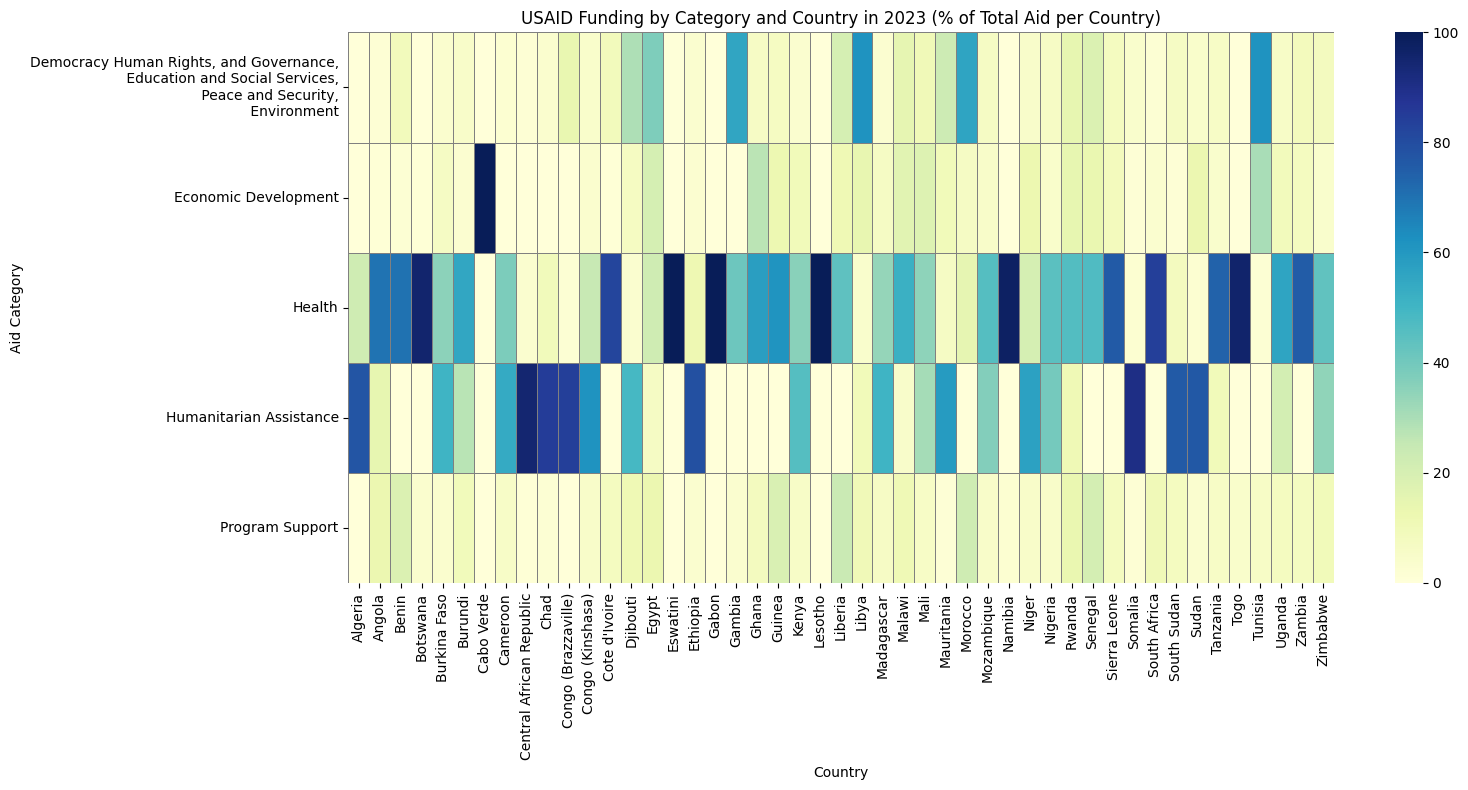

In [10]:
# Replace "Combined Categories" with the specified new label in 2023 data
merged_df["US Category Name"] = merged_df["US Category Name"].replace({
    "Combined Categories": "Democracy Human Rights, and Governance,\n Education and Social Services,\n Peace and Security,\n Environment"})

# Recreate the 2023 percentage heatmap with updated category name
merged_df_2023 = merged_df[merged_df["Year"] == 2023]
heatmap_data_2023 = (merged_df_2023.groupby(["Country Name", "US Category Name"])["Amount USD"].sum().reset_index())

heatmap_matrix_2023 = heatmap_data_2023.pivot(index="Country Name", columns="US Category Name", values="Amount USD").fillna(0)
country_totals = heatmap_matrix_2023.sum(axis=1)
heatmap_pct_2023 = heatmap_matrix_2023.div(country_totals, axis=0) * 100
heatmap_pct_2023_T = heatmap_pct_2023.T

# Plot the updated heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_pct_2023_T, cmap="YlGnBu", linewidths=0.5, linecolor='gray', annot=False)
plt.title("USAID Funding by Category and Country in 2023 (% of Total Aid per Country)")
plt.xlabel("Country")
plt.ylabel("Aid Category")
plt.tight_layout()
plt.show()


###Top and Bottom 10 Countries Receiving USAID Funds in 2023

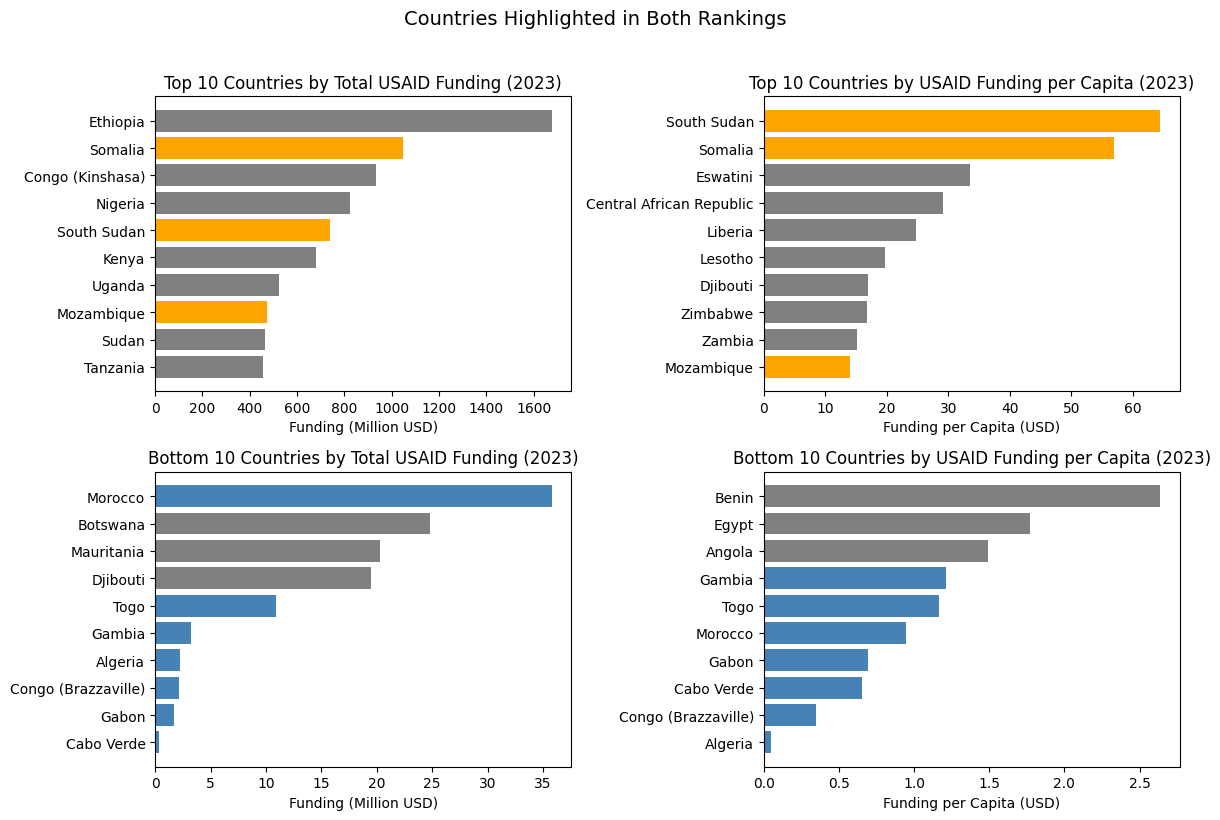

In [11]:
# Countries receiving the most USAID in 2023



# --- Aggregate funding at the country-year level ---
country_year_df = merged_df.groupby(["Year","Country Name","Income Group Acronym"]).agg({
    "Amount USD": "sum", "Population": "first", "GDP USD":"first"}).reset_index()

# --- Filter and prepare 2023 data ---
country_year_df_2023 = country_year_df[country_year_df["Year"]==2023]

# Calculate per capita funding
country_year_df_2023["Funding per Capita"] = (country_year_df_2023["Amount USD"] / country_year_df_2023["Population"])

# --- Top 10 lists ---
top_total_2023 = country_year_df_2023.nlargest(10, "Amount USD")
top_total_2023 = top_total_2023.sort_values(by="Amount USD", ascending=True).head(10)
top_per_capita_2023 = country_year_df_2023.nlargest(10, "Funding per Capita")
top_per_capita_2023 = top_per_capita_2023.sort_values(by="Funding per Capita", ascending=True).head(10)

# Identify overlapping countries
shared_countries = set(top_total_2023["Country Name"]) & set(top_per_capita_2023["Country Name"])

# Countries receiving the least USAID in 2023

# --- Top 10 lists ---
bottom_total_2023 = country_year_df_2023.nsmallest(10, "Amount USD")
bottom_per_capita_2023 = country_year_df_2023.nsmallest(10, "Funding per Capita")

# Identify overlapping countries
bottom_shared_countries = set(bottom_total_2023["Country Name"]) & set(bottom_per_capita_2023["Country Name"])



# ---Plots---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

# Left: Total funding
for _, row in top_total_2023.iterrows():
    color = "orange" if row["Country Name"] in shared_countries else "gray"
    axes[0, 0].barh(row["Country Name"], row["Amount USD"] / 1e6, color=color)
    axes[0, 0].set_title("Top 10 Countries by Total USAID Funding (2023)")
    axes[0, 0].set_xlabel("Funding (Million USD)")
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x')

# Right: Per capita funding
for _, row in top_per_capita_2023.iterrows():
    color = "orange" if row["Country Name"] in shared_countries else "gray"
    axes[0, 1].barh(row["Country Name"], row["Funding per Capita"], color=color)
    axes[0, 1].set_title("Top 10 Countries by USAID Funding per Capita (2023)")
    axes[0, 1].set_xlabel("Funding per Capita (USD)")
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x')

# Left: Total funding
for _, row in bottom_total_2023.iterrows():
    color = "steelblue" if row["Country Name"] in bottom_shared_countries else "gray"
    axes[1, 0].barh(row["Country Name"], row["Amount USD"] / 1e6, color=color)
    axes[1, 0].set_title("Bottom 10 Countries by Total USAID Funding (2023)")
    axes[1, 0].set_xlabel("Funding (Million USD)")
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x')

# Right: Per capita funding
for _, row in bottom_per_capita_2023.iterrows():
    color = "steelblue" if row["Country Name"] in bottom_shared_countries else "gray"
    axes[1, 1].barh(row["Country Name"], row["Funding per Capita"], color=color)
    axes[1, 1].set_title("Bottom 10 Countries by USAID Funding per Capita (2023)")
    axes[1, 1].set_xlabel("Funding per Capita (USD)")
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x')

plt.suptitle("Countries Highlighted in Both Rankings", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


##Correlation
* Is there correlation between USAID funding and GDP?
* How does funding relate to GDP per capita?


Explore the correlation between:

* USAID funding (Amount USD)

* GDP (GDP USD)

* Population

* GDP per capita

* USAID funding per capita (Amount per Capita)

### ScatterPlots

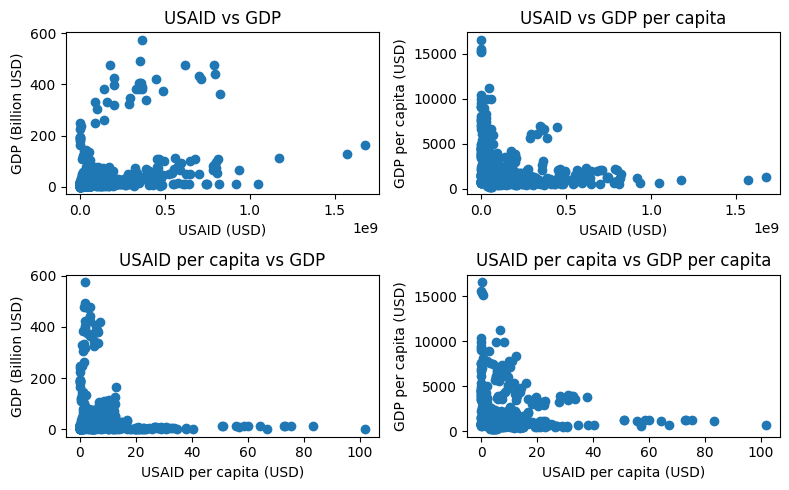

In [12]:
# Correlation Scatterplots

# country-year level
country_year_df = merged_df.groupby(["Year","Country Name",
                                     "Income Group Acronym"]).agg({"Amount USD": "sum",
                                                                   "Population": "mean",
                                                                   "GDP USD":"mean"}).reset_index()


# Create new columns for per capita values
country_year_df['GDP per Capita'] = country_year_df['GDP USD'] / country_year_df['Population']
country_year_df['Amount per Capita'] = country_year_df['Amount USD'] / country_year_df['Population']

country_year_df['GDP (Billion USD)'] = country_year_df['GDP USD'] / 1e9

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(8,5))

# Plot 1: USAID vs GDP
axes[0, 0].scatter(country_year_df['Amount USD'], country_year_df['GDP (Billion USD)'])
axes[0, 0].set_title('USAID vs GDP')
axes[0, 0].set_xlabel('USAID (USD)')
axes[0, 0].set_ylabel('GDP (Billion USD)')

# Plot 2: USAID vs GDP per capita
axes[0, 1].scatter(country_year_df['Amount USD'], country_year_df['GDP per Capita'])
axes[0, 1].set_title('USAID vs GDP per capita')
axes[0, 1].set_xlabel('USAID (USD)')
axes[0, 1].set_ylabel('GDP per capita (USD)')

# Plot 3: USAID per capita vs GDP
axes[1, 0].scatter(country_year_df['Amount per Capita'], country_year_df['GDP (Billion USD)'])
axes[1, 0].set_title('USAID per capita vs GDP')
axes[1, 0].set_xlabel('USAID per capita (USD)')
axes[1, 0].set_ylabel('GDP (Billion USD)')

# Plot 4: USAID per capita vs GDP per capita
axes[1, 1].scatter(country_year_df['Amount per Capita'], country_year_df['GDP per Capita'])
axes[1, 1].set_title('USAID per capita vs GDP per capita')
axes[1, 1].set_xlabel('USAID per capita (USD)')
axes[1, 1].set_ylabel('GDP per capita (USD)')

plt.tight_layout()
plt.show()

### Scatterplot Observation
* No visible signs of linear correlation. Try a non-linear transformation and inspect for outliers.

### Data Distribution

Numeric columns (excluding Year): ['Amount USD', 'Population', 'GDP USD', 'GDP per Capita', 'Amount per Capita', 'GDP (Billion USD)']


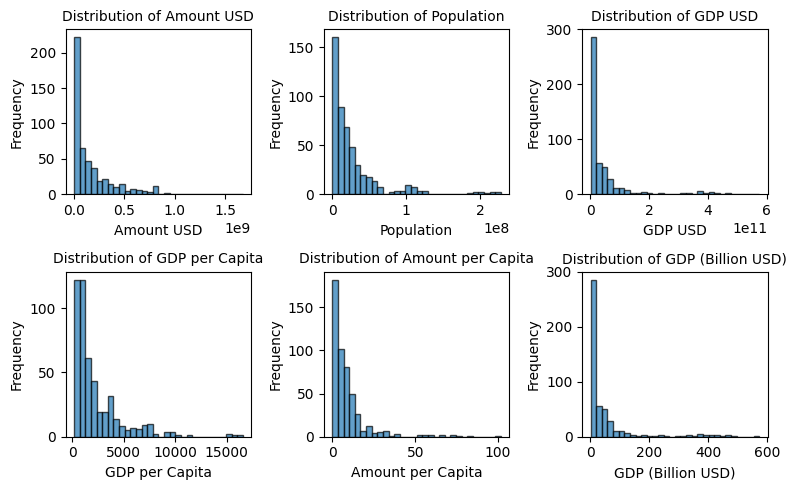

In [14]:
# Identify numeric columns excluding 'Year'
numeric_columns = [col for col in country_year_df.select_dtypes(include=[np.number]).columns if col != 'Year']
print("Numeric columns (excluding Year):", numeric_columns)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()  # Flatten to iterate easily over all axes

# Plot histogram for each numeric column on a separate subplot
for i, col in enumerate(numeric_columns):
    axes[i].hist(country_year_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Data Distribution Observation
* Skewed distributions. Try a non-linear transformation and inspect for outliers.
* Visualize with boxplots.

### Correlation Matrix

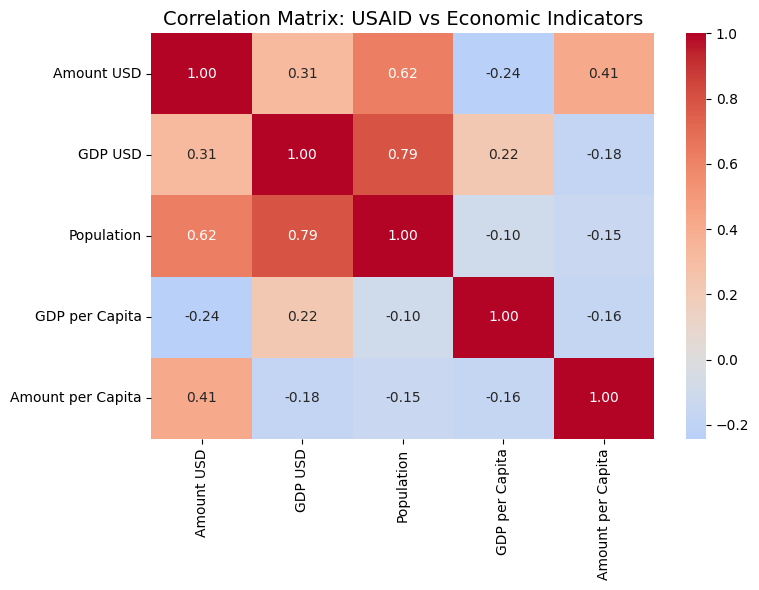

In [16]:
# Correlation Matrix

# country-year level
country_year_df = merged_df.groupby(["Year","Country Name",
                                     "Income Group Acronym"]).agg({"Amount USD": "sum",
                                                                   "Population": "mean",
                                                                   "GDP USD":"mean"}).reset_index()


# Create new columns for per capita values
country_year_df['GDP per Capita'] = country_year_df['GDP USD'] / country_year_df['Population']
country_year_df['Amount per Capita'] = country_year_df['Amount USD'] / country_year_df['Population']


# Select relevant columns for correlation analysis
correlation_data = country_year_df[["Amount USD", "GDP USD", "Population", "GDP per Capita", "Amount per Capita"]]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")

# Add title
plt.title("Correlation Matrix: USAID vs Economic Indicators", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Correlation Observations

### Correlation Matrix
* USAID funding (Amount USD) is not strongly correlated with GDP (0.31) or GDP Per Capita (-0.24).
* USAID per Capita (Amount per Capita) is not correlated with GDP metrics.
* GDP USD is highly correlated with Population (0.79), which makes sense — bigger countries tend to have higher GDPs.
* USAID (Amount) is moderately correlated with Population (.62).

####There is little evidence of a direct linear correlation between USAID funding and GDP metrics.


# Next Steps
Looking to take your analysis further? Here are a few ideas to continue your data sleuthing journey:

* Drill Down by Income Level: Group countries by World Bank income classification

* Year-over-Year Change Analysis: Investigate which countries saw the largest increases or decreases in aid across different categories over time.

* Aid Effectiveness Metrics: Bring in external indicators (e.g., poverty rates, health outcomes, education metrics) to explore correlations between aid received and development outcomes.

* Clustering: group countries with similar aid profiles